# Data Preparation

Read the 2 CSVs, join them and place the final dataset in joined_df

In [73]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim

import numpy as np
import torch
import random


In [74]:
# Load the data into a pandas DataFrame
data_path = "babaloon_kws_keywords - train_per_test.csv"
scores_csv_filepath = "babaloon_kws_keywords - Scores.csv"
my_test_size = 0.2  # 20% for testing


## Compile the list of unique words from the CSV


In [75]:
import csv
import json

# Define an empty list to store unique words
word_list = []

# Open the CSV file
with open(data_path, "r") as csvfile:
    # Read the CSV data using a reader object
    reader = csv.reader(csvfile)

    # Skip the header row
    next(reader)

    # Loop through each row in the CSV file
    for row in reader:
        # Get the JSON string from the second column
        json_data = row[1]
        json_data = json_data.replace("'", '"')
        # print(json_data)

        # Convert the JSON string to a dictionary
        data_dict = json.loads(json_data)
        # print("Dict =\t", data_dict)

        tr = json_data
        data_dict = eval(f"({tr})")
        # print(data_dict.keys())
        # print("Values:", data_dict.values())

        # Extract unique words from the dictionary keys and add them to the list
        for word in data_dict.keys():
            if word not in word_list:
                word_list.append(word)

# Print the unique word list
word_list.sort()
print(f"Unique words: {word_list}")
print(f"Number of unique words: {len(word_list)}")

Unique words: ['babaloon', 'balloon', 'boom', 'butterfly', 'gelukkig', 'geëet', 'hardloop', 'hond', 'honger', 'kat', 'katjie', 'kwaad', 'lekker', 'muis', 'seer', 'seuntjie', 'sien', 'vissies', 'voel', 'water', 'wil', 'worsies']
Number of unique words: 22


## Flatten and populate the feature columns from the dictionary


In [76]:
# Path to the new CSV file
output_csv_path = "babaloon_kws_keywords - flattened.csv"

# Read the original CSV
data = pd.read_csv(data_path)

# Initialize new columns with zeros
for word in word_list:
    data[word] = 0

# Save the updated DataFrame to the new CSV file (append mode)
data.to_csv(output_csv_path, header=True, index=False)

# print(data.head()) # Display the head of the new CSV with only 0s

In [77]:
# Load data from new csv and extract word counts
data = pd.read_csv(output_csv_path)

for index, row in data.iterrows():
    json_data = row["Keyword count"]
    json_data = json_data.replace("'", '"')
    # Convert the JSON string to a dictionary
    data_dict = json.loads(json_data)

    # Update the 0 value of the column matching the "key" word
    for word in data.columns[
        3:
    ]:  # Assuming columns from the 4th position onward are the words columns
        if word in data_dict:
            data.at[index, word] = data_dict[word]

data.to_csv(output_csv_path, header=True, index=False)

# print(data.head()) # Display the flattened table

scores_only = pd.read_csv(scores_csv_filepath)

# Perform an inner join
joined_df = pd.merge(data, scores_only, left_on="ID", right_on="Filename", how="inner")

# Drop the redundant 'Filename' column if needed
joined_df = joined_df.drop("Filename", axis=1)

# Save the updated DataFrame to the new CSV file (append mode)
joined_df.to_csv(output_csv_path, header=True, index=False)

# print(joined_df) # Display the result

# Training a Linear Regression Model

## Using PyTorch

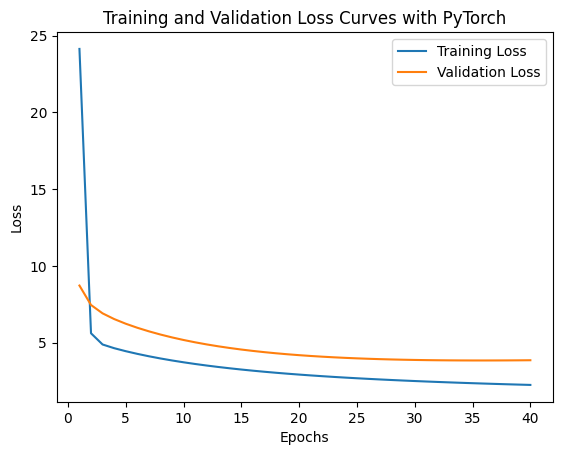

Mean Squared Error (MSE): 		3.849225495852044
Root Mean Squared Error (RMSE): 	1.9619443151761582
R-squared (R2): 			0.394220249833121


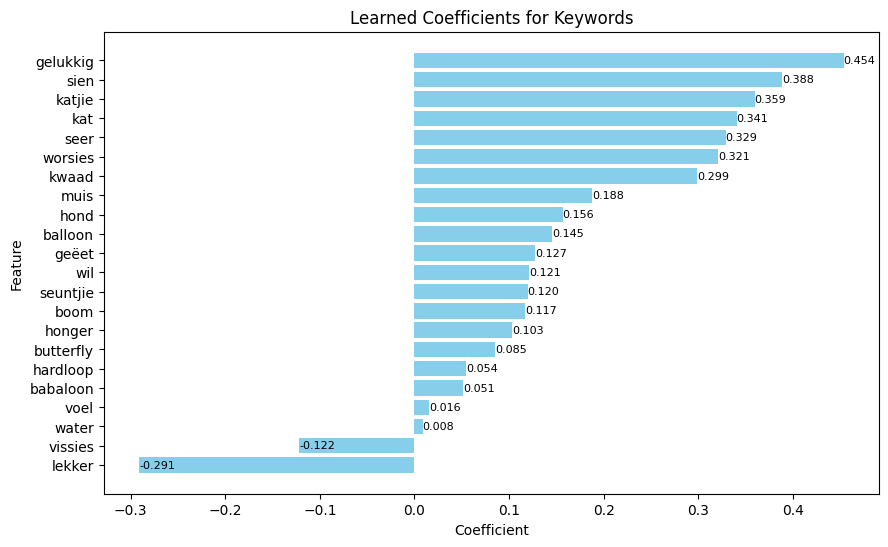

In [78]:
df = joined_df  # Set the data variable from the prepared dataframe
my_learning_rate = 0.01
num_epochs = 40
my_seed = 0
np.random.seed(my_seed)
torch.manual_seed(my_seed)
random.seed(my_seed)
#  lambda in scikit learn for regularisation

target = joined_df["A17"]
# target = joined_df["D11"]

# Set features to everything between Reviewed and A17
features = joined_df.loc[
    :,
    joined_df.columns[
        (joined_df.columns.get_loc("Reviewed") + 1) : joined_df.columns.get_loc("A17")
    ],
]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=my_test_size, random_state=my_seed
)

# Convert data to NumPy arrays and then to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Define the linear regression model
class LinearRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

# Instantiate the model
input_size = X_train_tensor.shape[1]
model = LinearRegressionModel(input_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=my_learning_rate)

# Training loop
train_losses = []
validation_losses = []

for epoch in range(num_epochs):
    # Forward pass for training data
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor.view(-1, 1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Forward pass for validation data
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor.view(-1, 1))
        validation_losses.append(val_loss.item())

# Plot the training and validation loss curves on the same plot
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), validation_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves with PyTorch")
plt.legend()
plt.show()

# Evaluation on test set
with torch.no_grad():
    y_pred = model(X_test_tensor)

mse = mean_squared_error(y_test, y_pred.numpy())
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred.numpy())

print(f"Mean Squared Error (MSE): \t\t{mse}")
print(f"Root Mean Squared Error (RMSE): \t{rmse}")
print(f"R-squared (R2): \t\t\t{r2}")

learned_coefficients = model.linear.weight.squeeze().tolist()
feature_names = list(features.columns)

coefficients_df = pd.DataFrame(
    {"Feature": feature_names, "Coefficient": learned_coefficients}
)
# Sort the DataFrame by the 'Feature' column
coefficients_df.sort_values(by="Feature", inplace=True)
# print(coefficients_df) # Print the sorted DataFrame

# Create a bar chart
coefficients_df = coefficients_df.sort_values(by="Coefficient")
plt.figure(figsize=(10, 6))
plt.barh(coefficients_df["Feature"], coefficients_df["Coefficient"], color="skyblue")
bars = plt.barh(
    coefficients_df["Feature"], coefficients_df["Coefficient"], color="skyblue"
)

# Add labels to the bars
for bar, label in zip(bars, coefficients_df["Coefficient"]):
    plt.text(
        bar.get_width(),
        bar.get_y() + bar.get_height() / 2,
        f"{label:.3f}",
        va="center",
        ha="left",
        fontsize=8,
    )
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.title("Learned Coefficients for Keywords")
plt.show()

## Using SciKit Learn


In [79]:


# Print only the header row
# print(joined_df.columns.tolist())

# Set features to everything between Reviewed and A17
features = joined_df.loc[
    :,
    joined_df.columns[
        (joined_df.columns.get_loc("Reviewed") + 1) : joined_df.columns.get_loc("A17")
    ],
]
# print(features)

target = joined_df["A17"]
# target = 'D11'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

# Standardize the features if necessary (optional)
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

X_train_scaled = X_train
X_test_scaled = X_test

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
predictions = model.predict(X_test_scaled)

# Get the coefficients and corresponding feature names
coefficients = model.coef_
feature_names = X_train.columns

# Create a DataFrame to display coefficients and feature names
print("Using SK Learn")
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Print the coefficients
print(coefficients_df)

# Print results table
print("\nFilename \t\t\t\t| True Value \t| Prediction \t| Error ")
print("-" * 60)  # Adjust length for new column

for row_index, (true_value, prediction, error) in enumerate(
    zip(y_test, predictions, y_test - predictions)
):
    # Extract filename from data DataFrame
    filename = data.loc[row_index, "ID"].split("_")[1:3]
    print(f"{filename} \t\t| {true_value:.2f} \t\t| {prediction:.2f} \t\t| {error:.2f}")

Using SK Learn
      Feature  Coefficient
0    babaloon     0.153610
1     balloon     0.174933
2        boom     0.140950
3   butterfly     0.024140
4    gelukkig     0.388431
5       geëet     0.561961
6    hardloop    -0.829359
7        hond    -0.153644
8      honger     0.203507
9         kat     0.177282
10     katjie     0.507314
11      kwaad     0.970671
12     lekker    -0.177581
13       muis     0.525111
14       seer     0.921300
15   seuntjie     0.327892
16       sien     0.406208
17    vissies    -0.179604
18       voel    -0.109508
19      water    -0.167383
20        wil     0.064415
21    worsies    -0.192535

Filename 				| True Value 	| Prediction 	| Error 
------------------------------------------------------------
['10', 'main'] 		| 5.00 		| 4.28 		| 0.72
['10', 'main'] 		| 5.00 		| 4.92 		| 0.08
['11', 'main'] 		| 11.00 		| 10.02 		| 0.98
['11', 'main'] 		| 8.00 		| 1.84 		| 6.16
['120', 'main'] 		| 9.00 		| 12.29 		| -3.29
['121', 'main'] 		| 5.00 		| 1.13 		|

### Plot the model results for SciKit Learn

Mean Squared Error: 6.4975313047432905
Root Mean Squared Error: 2.549025559845034
R-squared (R2): 0.15859306845050902
R-squared for Mean Predictions: 0.0


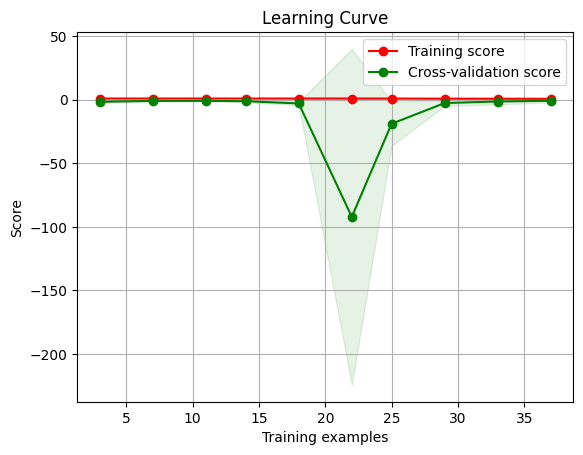

In [80]:

mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")

r2 = r2_score(y_test, predictions)
print(f"R-squared (R2): {r2}")

# Predict the mean of y_test for all samples
mean_predictions = np.full_like(predictions, y_test.mean())

# Calculate R2 for mean predictions
r2_mean_predictions = r2_score(y_test, mean_predictions)
print(f"R-squared for Mean Predictions: {r2_mean_predictions}")


# Plot learning curve
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    ylim=None,
    cv=None,
    n_jobs=1,
    train_sizes=np.linspace(0.1, 1.0, 10),
):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )

    plt.legend(loc="best")
    return plt


# Plot the learning curve
plot_learning_curve(model, "Learning Curve", X_train_scaled, y_train, cv=5, n_jobs=-1)

plt.show()